<a href="https://colab.research.google.com/github/thedatasense/llm-healthcare/blob/main/App-C%20-%20Building%20LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building LLM from Scratch

This part is heavily inspired based on the work by Sebastian Raschka
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>


In [45]:
!pip install tiktoken

In [46]:
from importlib.metadata import version
import os
import urllib.request
import importlib
import tiktoken
import torch
from torch.utils.data import DataLoader
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.5.1
tiktoken version: 0.8.0


In [85]:
# We will train our model on The Project Gutenberg eBooks
# You may copy it, give it away or re-use it under the terms
# of the Project Gutenberg License included with this ebook or online
# at www.gutenberg.org


# List of file URLs and their local paths
files = [
    {
        "url": "https://www.gutenberg.org/cache/epub/44200/pg44200.txt",
        "file_path": "pg44200.txt"
    },
    {
        "url": "https://www.gutenberg.org/cache/epub/16170/pg16170.txt",  # Example second file (Pride and Prejudice)
        "file_path": "pg16170.txt"
    },

    {
        "url":"https://www.gutenberg.org/cache/epub/59804/pg59804.txt",
        "file_path": "pg59804.txt"
        
    }
]

# Download files if they don't exist
for file in files:
    if not os.path.exists(file["file_path"]):
        urllib.request.urlretrieve(file["url"], file["file_path"])

# Read and combine text data from all files
text_data = ""
for file in files:
    with open(file["file_path"], "r", encoding="UTF-8") as f:
        text_data += f.read() + "\n"  # Add newline between file contents

# Display the total number of characters and a preview of the combined text
print("Total number of characters:", len(text_data))
print(text_data[:75])

Total number of characters: 1262174
﻿The Project Gutenberg eBook of The Reality of War: A Companion to Clausewi


**GPT-2 Tokenization: Byte-Pair Encoding **

- GPT-2 used Byte-Pair Encoding  as its tokenizer.
- It allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words.
- For instance, if GPT-2’s vocabulary doesn’t have the word *"unfamiliarword"*, it might tokenize it as `["unfam", "iliar", "word"]` or some other subword breakdown, depending on its trained BPE merges.
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)


In [86]:
tokenizer = tiktoken.get_encoding("gpt2")
enc_text = tokenizer.encode(text_data)
print("Total number of character:", len(enc_text))

Total number of character: 307356


In [87]:
context_size = 10
enc_sample = enc_text[200:]
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x: {x}")
print(f"y:      {y}")
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

x: [220, 29999, 25782, 4816, 379, 2638, 1378, 2503, 13, 6024]
y:      [29999, 25782, 4816, 379, 2638, 1378, 2503, 13, 6024, 26059]
  ---->  Proof
  Proof ----> reading
  Proofreading ---->  Team
  Proofreading Team ---->  at
  Proofreading Team at ---->  http
  Proofreading Team at http ----> ://
  Proofreading Team at http:// ----> www
  Proofreading Team at http://www ----> .
  Proofreading Team at http://www. ----> pg
  Proofreading Team at http://www.pg ----> dp


In [88]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
#Characters:→ Total raw characters in our text data.
print("Characters:", total_characters)
#Tokens:→ Number of units after applying the tokenizer (subwords, spaces, punctuation and so on)
print("Tokens:", total_tokens)

Characters: 1262174
Tokens: 307356


### Dataset

In [89]:
class LLMDataset(torch.utils.data.Dataset):
    def __init__(self,txt,tokenizer,max_len,stride):
        self.input_ids = []
        self.output_ids = []
        # Lets tokenize the entire input text
        token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"})

        # we use a sliding windows to chuck the text in to overlapping sequences of max lenght
        for i in range(0,len(token_ids) - max_len,stride):
            input_chunk = token_ids[i:i+max_len]
            target_chunk = token_ids[i+ 1 : i+max_len +1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.output_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.output_ids[idx]

Here we will code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

- `"vocab_size"` indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer
- `"context_length"` represents the model's maximum input token count, as enabled by positional embeddings covered
- `"emb_dim"` is the embedding size for token inputs, converting each input token into a 768-dimensional vector
- `"n_heads"` is the number of attention heads in the multi-head attention mechanism implemented
- `"n_layers"` is the number of transformer blocks within the model
- `"drop_rate"` is the dropout mechanism's intensity,.1 means dropping 10% of hidden units during training to mitigate overfitting
- `"qkv_bias"` decides if the `Linear` layers in the multi-head attention mechanism should include a bias vector when computing query (Q), key (K), and value (V) tensors;

In [90]:
def create_dataloader(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = LLMDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

### Transformer Architecture Setup

*   **Multi-Head Attention** learns relationships between inputs by projecting them into **queries**, **keys**, and **values**.
*   Input is split into multiple **heads**, each learning different attention patterns.
*   **Scaled dot-product attention** calculates similarity between queries and keys, creating attention weights.
*   A **causal mask** prevents the model from attending to future tokens in sequence generation.
*   Outputs from all heads are concatenated and projected, providing a context-aware representation.


In [91]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Dimension of each attention head

        # Linear projections for query, key, and value
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)

        # Causal mask to prevent attending to future tokens
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape  # Batch size, sequence length, input dimension

        # Project the input to query, key, and value
        keys = self.W_key(x)     # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x) # Shape: (b, num_tokens, d_out)
        values = self.W_value(x) # Shape: (b, num_tokens, d_out)

        # Split the projected vectors into multiple heads
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose to prepare for matrix multiplication
        # (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calculate attention scores (scaled dot-product attention)
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (b, num_heads, num_tokens, num_tokens)

        # Apply causal mask to attention scores
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Truncate mask to current sequence length
        attn_scores = attn_scores.masked_fill(mask_bool, float('-inf')) # Mask out future tokens

        # Normalize attention scores with softmax
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1) # Scale by sqrt(head_dim)

        # Apply dropout to attention weights
        attn_weights = self.dropout(attn_weights)

        # Calculate the weighted sum of values
        # (b, num_heads, num_tokens, num_tokens) @ (b, num_heads, num_tokens, head_dim) -> (b, num_heads, num_tokens, head_dim)
        context_vec = attn_weights @ values

        # Concatenate the outputs from all heads
        # (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)
        context_vec = context_vec.transpose(1, 2)

        # Reshape to combine heads: (b, num_tokens, num_heads, head_dim) -> (b, num_tokens, d_out)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)

        # Apply final linear projection
        context_vec = self.out_proj(context_vec)

        return context_vec

In [92]:
class GELU(nn.Module):
    """
    Implementation of the Gaussian Error Linear Unit (GELU) activation function.
    """
    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        Applies the GELU activation function element-wise.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after applying GELU.
        """
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


In [93]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [94]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

### Components of Transformer Block

#### 1. Multi-Head Attention (`self.att`)

*   **Purpose:** This is where the model learns to "attend" to different parts of the input sequence. It calculates relationships between words (or tokens) in the sequence, regardless of their distance. This is crucial for understanding context and long-range dependencies.
*   **How it works:**
    *   The input `x` is projected into three different representations: **queries (Q)**, **keys (K)**, and **values (V)**.
    *   The model calculates **attention scores** by taking the dot product of queries and keys, scaled down by the square root of the key dimension.
    *   These scores are passed through a softmax to get **attention weights**, representing the importance of each word to every other word.
    *   The attention weights are used to compute a weighted sum of the values, producing the **context vector**.
    *   This process is done multiple times in parallel with different learned projections (**multiple heads**), allowing the model to capture diverse relationships.
*   **Why it's important:** Unlike recurrent models (like RNNs), self-attention can process the entire sequence in parallel, making it much faster. It also directly models relationships between any two words, regardless of their position, which helps with long-range dependencies.

#### 2. Feed-Forward (`self.ff`)

*   **Purpose:** A simple, fully connected feed-forward network that processes each token's representation independently. This adds non-linearity and further transforms the information learned by the attention mechanism.
*   **How it works:** Typically, it consists of two linear layers with a non-linear activation function (like GELU or ReLU) in between.
*   **Why it's important:** It provides additional processing power and allows the model to learn more complex patterns from the attention outputs.

#### 3. LayerNorm (`self.norm1`, `self.norm2`)

*   **Purpose:** Layer normalization normalizes the activations across the feature dimension (embedding dimension). It helps stabilize training and can improve performance.
*   **How it works:** It subtracts the mean and divides by the standard deviation of the activations within each individual embedding vector (across the embedding dimension).
*   **Why it's important:** It prevents the activations from becoming too large or too small, which can lead to unstable gradients during training. It also makes the model less sensitive to the scale of the input features.

#### 4. Dropout (`self.drop_shortcut`)

*   **Purpose:** A regularization technique that randomly sets a fraction of the activations to zero during training. This helps prevent overfitting.
*   **How it works:** During each forward pass, it randomly "drops out" (sets to zero) a certain percentage of the activations, determined by the `drop_rate`.
*   **Why it's important:** It forces the model to learn more robust features that are not overly reliant on any single activation.

#### 5. Residual Connections (Shortcut Connections)

*   **Purpose:** The output of each sub-block (MHA and FFN) is added to its original input (`x = x + shortcut`). This helps with the flow of gradients during training, especially in deep networks.
*   **How it works:** The original input `x` is added to the output of the sub-block before being passed to the next layer.
*   **Why it's important:**
    *   **Vanishing Gradients:** In very deep networks, gradients can become very small as they are backpropagated through many layers, making training difficult. Residual connections provide a "shortcut" for the gradients to flow back, mitigating this problem.
    *   **Identity Mapping:** They make it easier for the network to learn the identity function (where the output is the same as the input). This is because if a layer is not needed, the network can easily learn to set its weights to zero, effectively making it pass through the input unchanged.

#### `forward(self, x)` Method:

The `forward` method defines how the input `x` is processed through the `TransformerBlock`:

1.  **Attention Block:**
    *   Store the original input for the residual connection.
    *   Apply layer normalization.
    *   Pass through the multi-head attention mechanism.
    *   Apply dropout to the output of the attention block
    *   Add the original input back (residual connection).

2.  **Feed-Forward Block:**
    *   Store the output from the attention block for the residual connection.
    *   Apply layer normalization.
    *   Pass through the feed-forward network.
    *   Apply dropout to the output of the feed-forward block.
    *   Add the output from the attention block back (residual connection).

3.  Return the processed output.

**In essence, the `TransformerBlock` takes an input sequence, allows it to attend to itself, processes it further with a feed-forward network, and uses layer normalization and residual connections to improve training and performance. Multiple `TransformerBlock` instances are stacked together to create the full Transformer model.**


In [95]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [96]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [97]:

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [99]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [100]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [101]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "When the enemy asks for directions"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 When the enemy asks for directions Caps � g batch shitty plasticsRoman atrocdaughterspan


In [102]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [103]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256])

In [104]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 276992
Validation tokens: 29952
All tokens: 306944


In [105]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cuda device.
Training loss: 10.991234655961973
Validation loss: 10.977656364440918


In [74]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [109]:

import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 7
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="The objective of war is ", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.845, Val loss 9.662
Ep 1 (Step 000005): Train loss 8.602, Val loss 8.244
Ep 1 (Step 000010): Train loss 7.817, Val loss 7.658
Ep 1 (Step 000015): Train loss 7.205, Val loss 7.487
Ep 1 (Step 000020): Train loss 7.294, Val loss 7.621
Ep 1 (Step 000025): Train loss 7.540, Val loss 7.475
Ep 1 (Step 000030): Train loss 7.543, Val loss 7.444
Ep 1 (Step 000035): Train loss 6.918, Val loss 7.369
Ep 1 (Step 000040): Train loss 7.193, Val loss 7.298
Ep 1 (Step 000045): Train loss 6.856, Val loss 7.179
Ep 1 (Step 000050): Train loss 6.799, Val loss 7.099
Ep 1 (Step 000055): Train loss 6.880, Val loss 7.066
Ep 1 (Step 000060): Train loss 7.010, Val loss 7.030
Ep 1 (Step 000065): Train loss 6.753, Val loss 7.020
Ep 1 (Step 000070): Train loss 6.696, Val loss 6.989
Ep 1 (Step 000075): Train loss 6.382, Val loss 6.905
Ep 1 (Step 000080): Train loss 6.401, Val loss 6.868
Ep 1 (Step 000085): Train loss 6.836, Val loss 6.893
Ep 1 (Step 000090): Train loss 6.441, Val loss

In [111]:
torch.save(model.state_dict(),"basic_llm.pth")

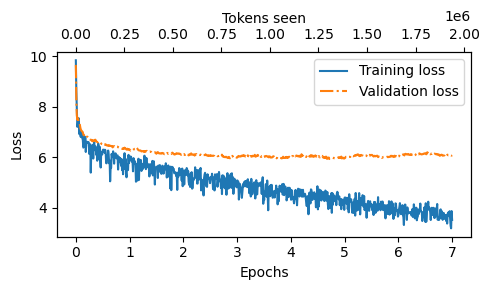

In [112]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [116]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Thou shall not", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Thou shall not
with the work, and the
the U.
















In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

**Top-k and Temperature**

 **Top-k** limits the model's choice to the *k* most probable next words, discarding less likely options. **Temperature** scales the probability distribution; higher values increase randomness by making the distribution more uniform, while lower values favor the most likely word by making it more peaked.  For instance, when creating a poem, high temperature with low Top-k might yield unusual word choices. Conversely, low temperature with high Top-k would produce a more predictable, coherent verse.  In essence, they dictate how "focused" versus "creative" the generated text becomes.

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you, I will spare for you. Here it was much
a gentleman and


In [ ]:
torch.save(model.state_dict(), "model.pth")